In [20]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Creating a sample dataset
np.random.seed(0)
experience = np.linspace(1, 10, 100)  # Years of experience
salary = 5000 + 4000 * experience + np.random.normal(0, 2000, 100)  # Salary with some noise

In [3]:
df = pd.DataFrame({'Experience': experience, 'Salary': salary})

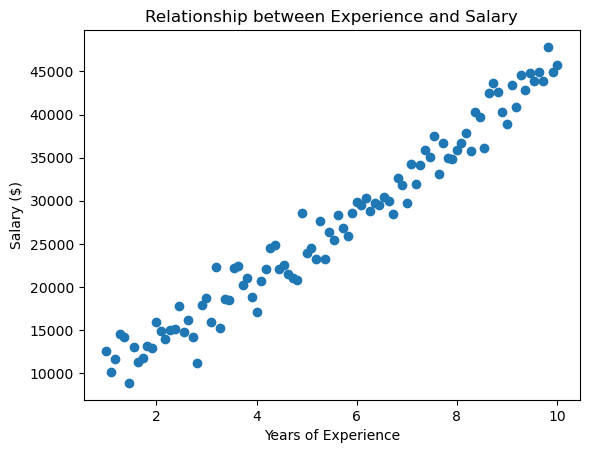

In [4]:
# Plotting the data
plt.scatter(df['Experience'], df['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary ($)')
plt.title('Relationship between Experience and Salary')
plt.show()

In [5]:
X = df[['Experience']]
y = df['Salary']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = model.predict(X_test)

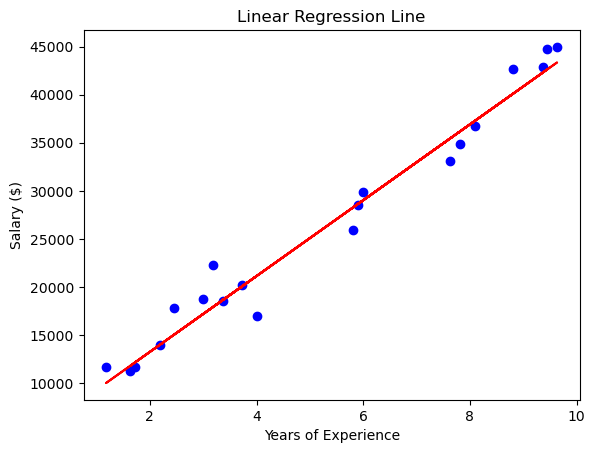

In [9]:
# Plotting the regression line
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.xlabel('Years of Experience')
plt.ylabel('Salary ($)')
plt.title('Linear Regression Line')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 3837490.13
R^2 Score: 0.97


In [19]:
# Calculate residuals
residuals = y_test - y_pred
sorted_residuals = np.sort(residuals)
cdf_residuals = np.arange(1, len(sorted_residuals) + 1) / len(sorted_residuals)
cdf_normal = norm.cdf(sorted_residuals)

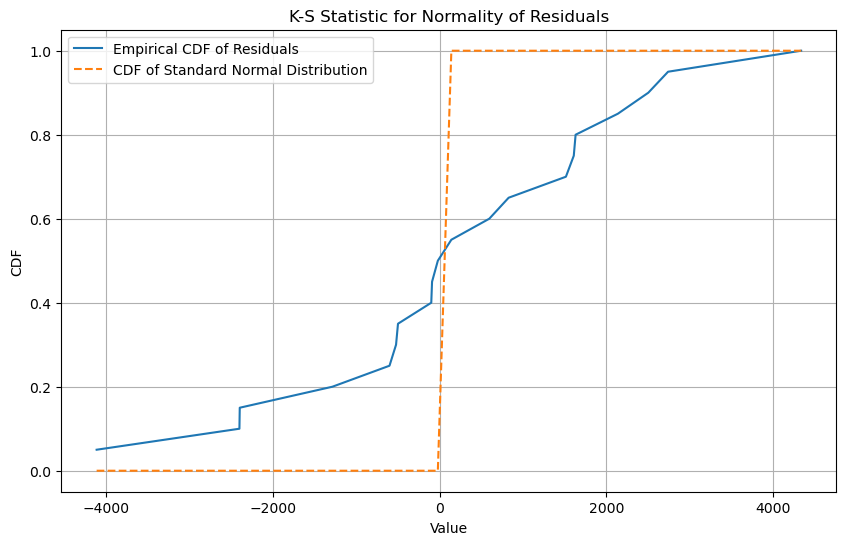

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_residuals, cdf_residuals, label='Empirical CDF of Residuals')
plt.plot(sorted_residuals, cdf_normal, label='CDF of Standard Normal Distribution', linestyle='--')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.title('K-S Statistic for Normality of Residuals')
plt.legend()
plt.grid(True)
plt.show()

## Kolmogorov-Smirnov (K-S) statistic

- The Kolmogorov-Smirnov (K-S) statistic is a non-parametric test used to compare a sample with a reference probability distribution or to compare two samples. It can be used to check the goodness of fit of a distribution to data.

- In this context, we can use the K-S test to check whether the residuals (difference between actual and predicted values) of our regression model follow a normal distribution.

In [12]:
from scipy.stats import kstest

# Testing if residuals follow a normal distribution
ks_statistic, ks_p_value = kstest(residuals, 'norm')

print(f"K-S Statistic: {ks_statistic:.2f}")
print(f"P-value: {ks_p_value:.2f}")

K-S Statistic: 0.50
P-value: 0.00


## The bin-based two-way Kolmogorov-Smirnov (K-S) test is a technique used to compare the distribution of actual and predicted values. It's particularly useful in the context of predictive models to understand if your model is consistently predicting across the full range of observed outcomes.

Here's how you can conduct a bin-based two-way K-S test:

- Create equal-sized bins based on the range of actual values.
- For each bin, compute the cumulative distribution function (CDF) for both actual and predicted values.
- Calculate the maximum difference between these CDFs.

In [13]:
# Number of bins
num_bins = 10

# Bin the actual values
bins = np.linspace(y_test.min(), y_test.max(), num_bins)
bin_indices = np.digitize(y_test, bins)

In [14]:
# Function to compute CDF for a given sample and value
def compute_cdf(sample, value):
    return np.mean(sample <= value)

In [15]:
actual_cdf_vals = []
predicted_cdf_vals = []

In [16]:
# For each bin, compute the CDF for actual and predicted values up to the bin's maximum value
for i in range(1, num_bins + 1):
    bin_max_value = bins[i-1]
    
    actual_cdf = compute_cdf(y_test, bin_max_value)
    predicted_cdf = compute_cdf(y_pred, bin_max_value)
    
    actual_cdf_vals.append(actual_cdf)
    predicted_cdf_vals.append(predicted_cdf)

In [17]:
# Calculate the K-S statistic as the maximum absolute difference between the actual and predicted CDFs
ks_statistic_2way = np.max(np.abs(np.array(actual_cdf_vals) - np.array(predicted_cdf_vals)))
print(f"Bin-based Two-way K-S Statistic: {ks_statistic_2way:.2f}")

Bin-based Two-way K-S Statistic: 0.05


### LIFT

LIFT is more commonly used in classification problems, particularly in the context of marketing campaigns where you'd want to see how much better a predictive model is at identifying positive cases compared to selecting at random. The idea is to compare the result of using a model versus not using it. It is typically used in conjunction with a gains or a decile table.

However, we can adapt the concept of LIFT to a regression context by categorizing predictions and actual values into bins and then calculating the lift value for each bin.

Here's a generalized approach to calculate LIFT:

- Rank the actual values and predictions.
- Divide the ranked list into deciles (or any other number of bins you'd prefer).
- Calculate the average of the actual values for each bin.
- Calculate the average of the predicted values for each bin.
- Calculate the lift as the ratio of the average of the actual to the predicted values for each bin.

In [23]:
# Number of bins (deciles in this case)
num_bins = 10

# Create bins for the predicted values
predicted_bins = pd.qcut(y_pred, q=num_bins, labels=False, duplicates='drop')

In [24]:
# Create a dataframe to compute LIFT
df_lift = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'predicted_bin': predicted_bins})

In [25]:
# Group by bins to calculate the lift
lift_df = df_lift.groupby('predicted_bin').agg(
    avg_actual=('actual', 'mean'),
    avg_predicted=('predicted', 'mean')
)

In [26]:
# Calculate lift
lift_df['lift'] = lift_df['avg_actual'] / lift_df['avg_predicted']
lift_df

,avg_actual,avg_predicted,lift
predicted_bin,,,
0,11463.744412,10948.748358,1.047037
1,12836.637983,13096.857540,0.980131
2,18267.606181,16140.012215,1.131821
3,20406.422232,18288.121398,1.115829
4,18628.696412,20615.239679,0.903637
5,27245.731042,28491.640015,0.956271
6,31466.233323,32250.831084,0.975672
7,35821.819195,36726.058548,0.975379
8,42750.690913,41201.286011,1.037606


## Cumulative lift

In the context of classification, cumulative lift typically means the lift value up to a particular decile (or bin). When you cumulate the lift, you consider all records up to that decile and compare the result with a baseline (usually random selection).

For regression, the idea is a bit different, but we can follow a similar methodology:

- Rank the predictions.
- Create deciles (or any other number of bins) based on the ranked predictions.
- For each decile, calculate the cumulative average of the actual values and the cumulative average of the predicted values.
- Calculate the cumulative lift as the ratio of the cumulative average of the actual values to the cumulative average of the predicted values.

In [28]:
# Create bins for the predicted values
predicted_bins = pd.qcut(y_pred, q=num_bins, labels=False, duplicates='drop')

# Create a dataframe to compute LIFT
df_lift = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'predicted_bin': predicted_bins})

In [29]:
# Group by bins to calculate the average values
lift_df = df_lift.groupby('predicted_bin').agg(
    avg_actual=('actual', 'mean'),
    avg_predicted=('predicted', 'mean')
).reset_index()

In [30]:
# Calculate cumulative averages
lift_df['cumulative_avg_actual'] = lift_df['avg_actual'].expanding().mean()
lift_df['cumulative_avg_predicted'] = lift_df['avg_predicted'].expanding().mean()

In [31]:
# Calculate cumulative lift
lift_df['cumulative_lift'] = lift_df['cumulative_avg_actual'] / lift_df['cumulative_avg_predicted']
lift_df[['predicted_bin', 'cumulative_lift']]

,predicted_bin,cumulative_lift
0,0,1.047037
1,1,1.010596
2,2,1.059284
3,3,1.076969
4,4,1.031789
5,5,1.011789
6,6,1.003459
7,7,0.997618
8,8,1.005184
9,9,1.011515


### AIC (Akaike Information Criterion): 
    - Balances model fit with model complexity. It can be used for model selection.

- AIC is a measure of the goodness of fit of a model. It takes into account the number of parameters used, penalizing the addition of unnecessary parameters. In model selection, a model with a lower AIC is generally preferred.

- BIC, like the AIC, is a measure of model fit that takes into account model complexity. However, BIC imposes a higher penalty for including additional parameters to the model compared to AIC. When comparing models, a lower BIC value indicates a better model in terms of the balance between fit and complexity.

In [33]:
import statsmodels.api as sm

In [34]:
# Add a constant term to the predictor for statsmodels
X_train_const = sm.add_constant(X_train)

In [37]:
# Fit the OLS model using statsmodels
model = sm.OLS(y_train, X_train_const).fit()
print("AIC: ", model.aic)
print("BIC: ", model.bic)

AIC:  1448.8928959723753
BIC:  1453.6569492417232


## Learning curves

- Learning curves provide insights into how the performance of a machine learning model improves over time with more data. They're especially useful for understanding if your model is benefiting from adding more training data and if the model is overfitting or underfitting.

#### From the learning curve, you can infer:

- If both curves converge to a high error, the model is underfitting.
- If there's a large gap between the curves, the model might be overfitting.
- If both curves converge and are close to each other at a low error rate, the model is probably a good fit for the data.
- If the cross-validation score continues to improve as data is added, then even more data might be beneficial. If the cross-validation score plateaus despite adding more data, then additional data might not be as valuable.

In [39]:
from sklearn.model_selection import learning_curve

In [42]:
# Define the model
model = LinearRegression()

# Using the full dataset for learning_curve
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [43]:
# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_full, y_full, cv=10, scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

In [44]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

In [45]:
# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

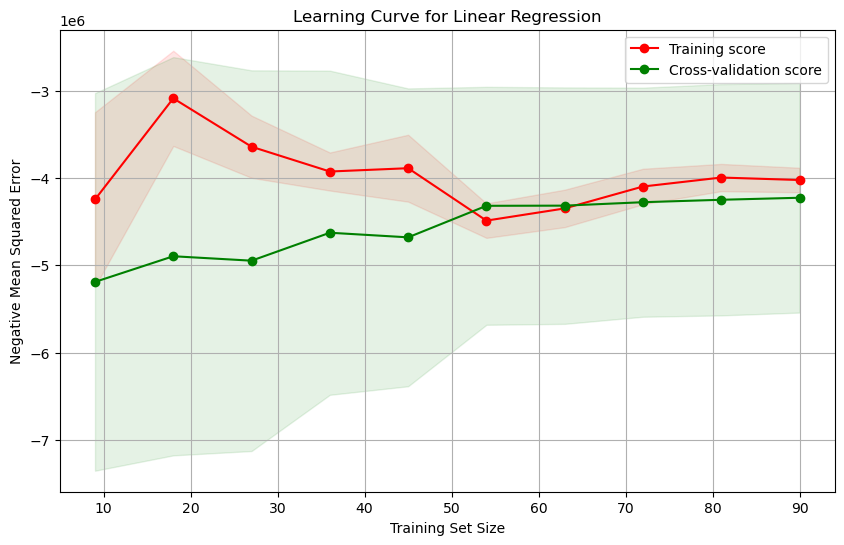

In [46]:
# Plot the learning curve
plt.figure(figsize=(10,6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for Linear Regression")
plt.xlabel("Training Set Size")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.grid()
plt.show()

### Bootstrap Resampling

- Bootstrapping is a powerful statistical method for estimating the distribution of a statistic (like the mean or variance) by resampling with replacement from the data. It's particularly useful when the theoretical distribution of the statistic is complicated or unknown.

- Elasticity is indeed an essential concept in economics and is especially useful when understanding relationships between variables in log-log models. The elasticity in a log-log model can be interpreted as the percentage change in the dependent variable for a 1% change in the independent variable, and this is directly given by the coefficient of the independent variable.

- For our case, we can use bootstrapping to estimate the distribution of the elasticity coefficient from the log-log regression model.

In [50]:
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
# Convert Experience and Salary into log form
log_X = np.log(X_train)
log_y = np.log(y_train)

In [51]:
# Number of bootstrap samples to create
B = 1000
bootstrap_elasticities = []

for _ in range(B):
    # Step 1: Create a bootstrap sample
    X_sample, y_sample = resample(log_X, log_y)
    
    # Step 2: Compute elasticity
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    bootstrap_elasticities.append(model.coef_[0])

In [52]:
# Calculate mean and confidence intervals for elasticity
mean_elasticity = np.mean(bootstrap_elasticities)
confidence_lower = np.percentile(bootstrap_elasticities, 2.5)
confidence_upper = np.percentile(bootstrap_elasticities, 97.5)

print(f"Mean Elasticity from Bootstrap: {mean_elasticity:.4f}")
print(f"95% Confidence Interval: ({confidence_lower:.4f}, {confidence_upper:.4f})")

Mean Elasticity from Bootstrap: 0.6821
95% Confidence Interval: (0.6153, 0.7571)


## Jackknife resampling

Jackknife resampling is another resampling technique that's used to estimate the bias and variance of a statistical estimator. Unlike bootstrapping where we sample with replacement, in the jackknife method, we systematically leave out one observation at a time from the sample set and calculate the estimate over n-1 observations.

Here's the process for the jackknife:

For each observation in the dataset:
- Remove the observation.
- Fit the model to the remaining data.
- Compute the statistic of interest (in our case, the elasticity coefficient in the log-log model).
- Aggregate the results to get a sense of the variability in the statistic.

In [54]:
jackknife_elasticities = []

# Iterate over all samples
for i in range(len(log_X)):
    # Exclude the i-th observation
    X_exclude_i = log_X.drop(index=log_X.index[i])
    y_exclude_i = log_y.drop(index=log_y.index[i])
    
    # Fit the model and compute the elasticity
    model = LinearRegression()
    model.fit(X_exclude_i, y_exclude_i)
    jackknife_elasticities.append(model.coef_[0])

In [55]:
# Calculate the jackknife estimate for the mean
mean_elasticity_jackknife = np.mean(jackknife_elasticities)

In [56]:
# For variance: variance = (n-1) * mean of (theta_i - theta_dot)^2
# where theta_i is the estimate from the i-th sample, and theta_dot is the overall mean estimate
variance_jackknife = (len(log_X) - 1) * np.mean((jackknife_elasticities - mean_elasticity_jackknife) ** 2)

print(f"Jackknife Mean Elasticity: {mean_elasticity_jackknife:.4f}")
print(f"Jackknife Variance of Elasticity: {variance_jackknife:.4f}")

Jackknife Mean Elasticity: 0.6765
Jackknife Variance of Elasticity: 0.0015


## Cook's Distance

- Cook's Distance is a measure used in regression analysis to identify influential observations. It helps in detecting data points that might be unduly influencing the regression results.

- The Cook's Distance combines information about both the leverage and the residuals of the observation. Observations with a Cook's Distance larger than three times the mean might be considered as influential.

In [59]:
# Adding a constant to the model (required for statsmodels)
X_train_with_const = sm.add_constant(X_train)

In [60]:
# Fitting the regression model
model = sm.OLS(y_train, X_train_with_const).fit()

In [61]:
# Calculating Cook's Distance
influence = model.get_influence()
cooks_distance = influence.cooks_distance[0]

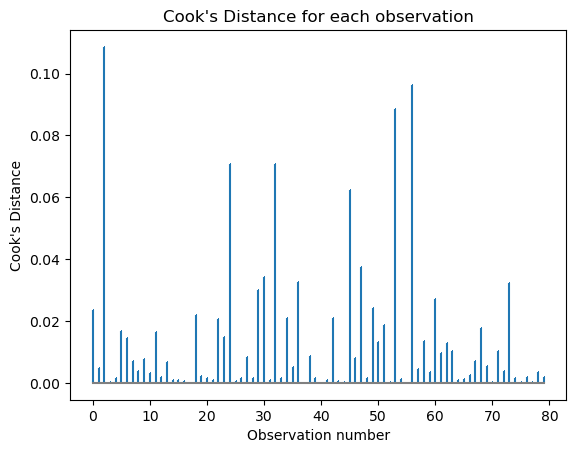

In [62]:
# Plotting Cook's Distance
plt.stem(np.arange(len(cooks_distance)), cooks_distance, markerfmt=",", basefmt="gray")
plt.title("Cook's Distance for each observation")
plt.xlabel("Observation number")
plt.ylabel("Cook's Distance")
plt.show()

In [63]:
# Identifying influential points
influential_points = np.where(cooks_distance > 3 * np.mean(cooks_distance))[0]
print("Potentially Influential Points:", influential_points)

Potentially Influential Points: [ 2 24 32 45 53 56]


## Leverage

- Leverage measures how much an observation's value on the predictor variable (or variables) differs from the mean of the predictor variable(s). Observations with predictor values far from the mean tend to have higher leverage.

- Leverage values range from p/n to 1, where p is the number of predictors and n is the number of observations. A rule of thumb is that observations with a leverage value more than 2 * (p/n) might be considered high leverage points.

In [65]:
# Calculating leverage
influence = model.get_influence()
leverage = influence.hat_matrix_diag

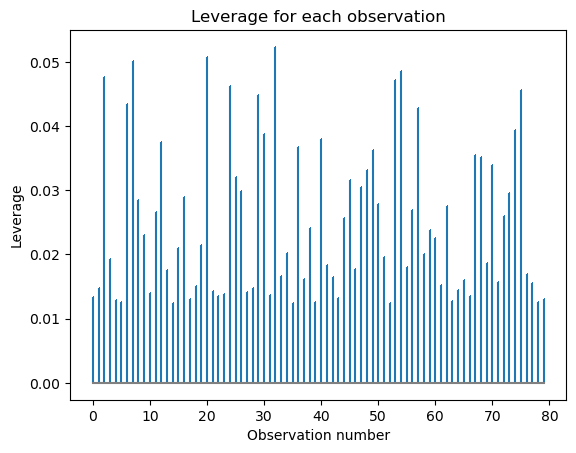

In [66]:
# Plotting leverage values
plt.stem(np.arange(len(leverage)), leverage, markerfmt=",", basefmt="gray")
plt.title("Leverage for each observation")
plt.xlabel("Observation number")
plt.ylabel("Leverage")
plt.show()

In [67]:
# Identifying high leverage points
p = X_train_with_const.shape[1]  # Number of predictors (including the constant)
n = len(X_train)
high_leverage_points = np.where(leverage > 2*p/n)[0]
print("High Leverage Points:", high_leverage_points)

High Leverage Points: [ 7 20 32]


## Mahalanobis Distance:

- Measures the distance of a point from a distribution. In regression, it's used to detect outliers in multivariate data.
- The Mahalanobis distance is a measure of the distance between a point P and a distribution D. It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. This distance is zero if P is at the mean of D, and grows as P moves away from the mean.

In [71]:
import scipy as sp

In [72]:
X = df[['Experience', 'Salary']]

In [73]:
# Calculate the Mahalanobis Distance
def mahalanobis_distance(x, data):
    """Compute the Mahalanobis Distance between each row of x and the data"""
    x_minus_mu = x - np.mean(data)
    cov = np.cov(data.values, rowvar=0)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [74]:
distances = mahalanobis_distance(X, X)

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


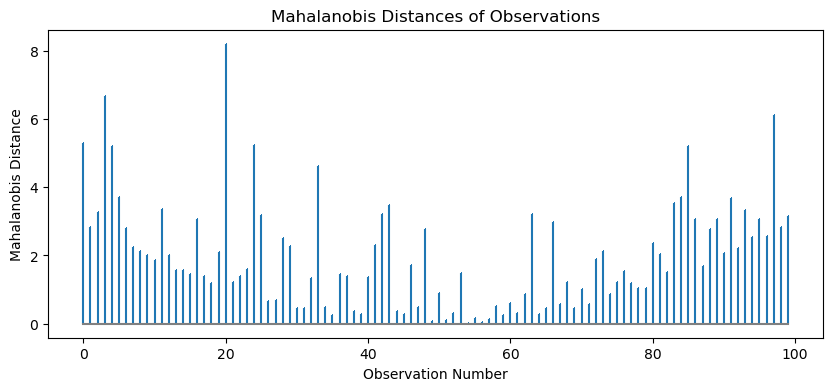

In [75]:
# Plotting the Mahalanobis distances
plt.figure(figsize=(10,4))
plt.stem(np.arange(len(distances)), distances, markerfmt=",", basefmt="gray")
plt.title("Mahalanobis Distances of Observations")
plt.xlabel("Observation Number")
plt.ylabel("Mahalanobis Distance")
plt.show()